# Morphometric Measure Comparision between Manual and Automatic

In [80]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from skimage import io
from tqdm import tqdm
from scipy import stats

from utils.utils import read_csv, load_config
from measurements.measurements import get_function_dict, plot_image

In [81]:
def bland_altman_plot(data1, data2, ax=None, title='Bland-Altman Plot', xlabel='Mean of Two Measurements', ylabel='Difference Between Measurements', save_path=None, *args, **kwargs):
    """
    Creates a Bland-Altman plot to compare two sets of measurements.

    Parameters:
    data1, data2 : array-like
        The two sets of measurements to compare.
    """

    small_font_size = 12
    large_font_size = 14

    # The number of standard deviations to use for the limits of agreement (default is 1.96 for ~95% limits).
    limit=1.96

    # Calculate the mean and difference between measurements
    data1, data2 = np.array(data1), np.array(data2)
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)  # Mean difference
    sd = np.std(diff, axis=0)  # Standard deviation of differences

    # If no axis is provided, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    # Plotting on the specified axis
    ax.scatter(mean, diff, *args, **kwargs)

    # Plot lines for mean difference and limits of agreement
    ax.axhline(md, color='gray', linestyle='-')
    ax.axhline(md + limit * sd, color='gray', linestyle='--')
    ax.axhline(md - limit * sd, color='gray', linestyle='--')

    # Add labels at the end of each line (outside the plot area on the right)
    x_lim = plt.gca().get_xlim()[1]  # Right edge of the plot
    y_lim = plt.gca().get_ylim() # Top and bottom edge of the plot
    y_lim_diff = y_lim[1] - y_lim[0]

    ax.text(x_lim, md + y_lim_diff*0.03, 'Mean', color='gray', va='center', ha='right', fontsize=small_font_size)
    ax.text(x_lim, md - y_lim_diff*0.035, '{0:.2f}'.format(md), color='gray', va='center', ha='right', fontsize=small_font_size)

    ax.text(x_lim, md + limit*sd + y_lim_diff*0.03, r'+1.96 SD', color='gray', va='center', ha='right', fontsize=small_font_size)
    ax.text(x_lim, md + limit*sd - y_lim_diff*0.035, '{0:.2f}'.format(md+limit*sd), color='gray', va='center', ha='right', fontsize=small_font_size)
    
    ax.text(x_lim, md - limit*sd + y_lim_diff*0.03, r'-1.96 SD', color='gray', va='center', ha='right', fontsize=small_font_size)
    ax.text(x_lim, md - limit*sd - y_lim_diff*0.035, '{0:.2f}'.format(md-limit*sd), color='gray', va='center', ha='right', fontsize=small_font_size)

    # Adjust plot limits to accommodate text labels on the right
    ax.set_xlabel(xlabel, fontsize=large_font_size)
    ax.set_ylabel(ylabel, fontsize=large_font_size)
    ax.set_title(title, fontsize=large_font_size)
    ax.tick_params(axis='both', labelsize=small_font_size) 
    plt.tight_layout()

    if not save_path is None:
        plt.savefig(os.path.join(save_path, title+'.png'), bbox_inches="tight", pad_inches=0)

'''
# Example data
method1 = [100, 102, 104, 98, 100, 102, 99, 97, 101, 100]
method2 = [102, 100, 105, 99, 101, 103, 100, 96, 100, 98]

# Generate Bland-Altman plot
bland_altman_plot(method1, method2)
'''

'\n# Example data\nmethod1 = [100, 102, 104, 98, 100, 102, 99, 97, 101, 100]\nmethod2 = [102, 100, 105, 99, 101, 103, 100, 96, 100, 98]\n\n# Generate Bland-Altman plot\nbland_altman_plot(method1, method2)\n'

In [82]:
general_information_columns = ['Category', 'Datum', 'Zeit', 'Patienten-ID', 'Untersuchungsnummer', 'Patientenname', 'Geburtsdatum', 'Alter', 'Geschlecht', 'Beschreibung', 'Views', 'Mod.', 'Folder Number']

measurement_files = {
    'Felix': {
        'Feet': {
            'LATERAL': [r'E:\data\UKAFeetX\ManualMeasurements_feet_Felix.xlsx', 'LATERAL'],
            'AP': [r'E:\data\UKAFeetX\ManualMeasurements_feet_Felix.xlsx', 'AP'],
        },
        'Knee': {
            'LATERAL': [r'E:\data\UKAKneeX\ManualMeasurements_knee_Felix.xlsx', 'LATERAL'],
            'AP': [r'E:\data\UKAKneeX\ManualMeasurements_knee_Felix.xlsx', 'AP'],
            'AXIAL': [r'E:\data\UKAKneeX\ManualMeasurements_knee_Felix.xlsx', 'PATELLA AXIAL']
        },
        'Shoulder': {
            'AP': [r'E:\data\UKAShoulderX\ManualMeasurements_shoulder_Felix.xlsx', 'Sheet1']
        }
    },
    'Eneko': {
        'Feet': {
            'LATERAL': [r'E:\data\UKAFeetX\ManualMeasurements_feet_Eneko.xlsx', 'LATERAL'],
            'AP': [r'E:\data\UKAFeetX\ManualMeasurements_feet_Eneko.xlsx', 'AP'],
            'LATERAL_EXTRA': [r'E:\data\UKAFeetX\ManualMeasurements_feetExtra_Eneko.xlsx', 'LATERAL'],
            'AP_EXTRA': [r'E:\data\UKAFeetX\ManualMeasurements_feetExtra_Eneko.xlsx', 'AP'],
        },
        'Knee': {
            'LATERAL': [r'E:\data\UKAKneeX\ManualMeasurements_knee_Eneko.xlsx', 'LATERAL'],
            'AP': [r'E:\data\UKAKneeX\ManualMeasurements_knee_Eneko.xlsx', 'AP'],
            'AXIAL': [r'E:\data\UKAKneeX\ManualMeasurements_knee_Eneko.xlsx', 'PATELLA AXIAL'],
            'LATERAL_EXTRA': [r'E:\data\UKAKneeX\ManualMeasurements_kneeExtra_Eneko.xlsx', 'LATERAL'],
            'AP_EXTRA': [r'E:\data\UKAKneeX\ManualMeasurements_kneeExtra_Eneko.xlsx', 'AP'],
            'AXIAL_EXTRA': [r'E:\data\UKAKneeX\ManualMeasurements_kneeExtra_Eneko.xlsx', 'PATELLA AXIAL']
        },
        'Shoulder': {
            'AP': [r'E:\data\UKAShoulderX\ManualMeasurements_shoulder_Eneko.xlsx', 'Sheet1'],
            'AP_EXTRA': [r'E:\data\UKAShoulderX\ManualMeasurements_shoulderExtra_Eneko.xlsx', 'Sheet1']
        },
        'Hip': {
            'AP': [r'E:\data\UKAHipX\TESt1_age_mesvalues.xlsx', 'Sheet1'],
        }
    },
    'Automated': {
        'Feet': {
            'LATERAL': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_lateral.csv', 'Sheet1'],
            'LATERAL_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_lateral_bulk5.csv', 'Sheet1'],
            'LATERAL_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_lateral_bulk10.csv', 'Sheet1'],
            'LATERAL_bulk20': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_lateral_bulk20.csv', 'Sheet1'],
            'LATERAL_bulk40': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_lateral_bulk40.csv', 'Sheet1'],
            'LATERAL_EXTRA': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_lateral_extra.csv', 'Sheet1'],
            'LATERAL_EXTRA_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_lateral_extra_bulk5.csv', 'Sheet1'],
            'LATERAL_EXTRA_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_lateral_extra_bulk10.csv', 'Sheet1'],
            'AP': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_ap.csv', 'Sheet1'],
            'AP_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_ap_bulk5.csv', 'Sheet1'],
            'AP_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_ap_bulk10.csv', 'Sheet1'],
            'AP_bulk20': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_ap_bulk20.csv', 'Sheet1'],
            'AP_bulk40': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_ap_bulk40.csv', 'Sheet1'],
            'AP_EXTRA': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_ap_extra.csv', 'Sheet1'],
            'AP_EXTRA_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_ap_extra_bulk5.csv', 'Sheet1'],
            'AP_EXTRA_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_feet_ap_extra_bulk10.csv', 'Sheet1'],
        },
        'Knee': {
            'LATERAL': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_lateral.csv', 'Sheet1'],
            'LATERAL_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_lateral_bulk5.csv', 'Sheet1'],
            'LATERAL_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_lateral_bulk10.csv', 'Sheet1'],
            'LATERAL_bulk20': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_lateral_bulk20.csv', 'Sheet1'],
            'LATERAL_bulk40': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_lateral_bulk40.csv', 'Sheet1'],
            'LATERAL_EXTRA': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_lateral_extra.csv', 'Sheet1'],
            'LATERAL_EXTRA_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_lateral_extra_bulk5.csv', 'Sheet1'],
            'LATERAL_EXTRA_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_lateral_extra_bulk10.csv', 'Sheet1'],
            'AP': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_ap.csv', 'Sheet1'],
            'AP_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_ap_bulk5.csv', 'Sheet1'],
            'AP_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_ap_bulk10.csv', 'Sheet1'],
            'AP_bulk20': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_ap_bulk20.csv', 'Sheet1'],
            'AP_bulk40': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_ap_bulk40.csv', 'Sheet1'],
            'AP_EXTRA': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_ap_extra.csv', 'Sheet1'],
            'AP_EXTRA_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_ap_extra_bulk5.csv', 'Sheet1'],
            'AP_EXTRA_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_ap_extra_bulk10.csv', 'Sheet1'],
            'AXIAL': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_axial.csv', 'Sheet1'],
            'AXIAL_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_axial_bulk5.csv', 'Sheet1'],
            'AXIAL_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_axial_bulk10.csv', 'Sheet1'],
            'AXIAL_bulk20': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_axial_bulk20.csv', 'Sheet1'],
            'AXIAL_bulk40': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_axial_bulk40.csv', 'Sheet1'],
            'AXIAL_EXTRA': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_axial_extra.csv', 'Sheet1'],
            'AXIAL_EXTRA_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_axial_extra_bulk5.csv', 'Sheet1'],
            'AXIAL_EXTRA_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_knee_axial_extra_bulk10.csv', 'Sheet1'],
        },
        'Shoulder': {
            'AP': [r'E:\experiments\MSK_Landmarks_2D\measurements_shoulder_ap.csv', 'Sheet1'],
            'AP_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_shoulder_ap_bulk5.csv', 'Sheet1'],
            'AP_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_shoulder_ap_bulk10.csv', 'Sheet1'],
            'AP_bulk20': [r'E:\experiments\MSK_Landmarks_2D\measurements_shoulder_ap_bulk20.csv', 'Sheet1'],
            'AP_bulk40': [r'E:\experiments\MSK_Landmarks_2D\measurements_shoulder_ap_bulk40.csv', 'Sheet1'],
            'AP_EXTRA': [r'E:\experiments\MSK_Landmarks_2D\measurements_shoulder_ap_extra.csv', 'Sheet1'],
            'AP_EXTRA_bulk5': [r'E:\experiments\MSK_Landmarks_2D\measurements_shoulder_ap_extra_bulk5.csv', 'Sheet1'],
            'AP_EXTRA_bulk10': [r'E:\experiments\MSK_Landmarks_2D\measurements_shoulder_ap_extra_bulk10.csv', 'Sheet1'],
        },
        'Hip': {
            'AP': [r'E:\experiments\MSK_Landmarks_2D\ROMA_Hip_MultiRef\measurements_hip_ap.csv', 'measurements_hip_ap'],
        }
    }
}

In [347]:
anatomy = 'Shoulder'
measurement_type = 'AP_EXTRA'
# measurement_files_1 = [measurement_files['Felix'][anatomy][measurement_type], measurement_files['Eneko'][anatomy][measurement_type]]
measurement_files_1 = [measurement_files['Eneko'][anatomy][measurement_type]]
measurement_file_2 = measurement_files['Automated'][anatomy][measurement_type]
# measurement_file_2 = measurement_files['Eneko'][anatomy][measurement_type]

# Load measurement file
def load_measurement_file(measurement_file):
    print(measurement_file)
    if measurement_file[0].endswith('.xlsx'):
        measurement_data = pd.read_excel(measurement_file[0], sheet_name=measurement_file[1])
    else:
        measurement_data = pd.read_csv(measurement_file[0], sep=',')

        # Split the first column into two new columns
        # You can customize the split logic based on your data format
        split_columns = measurement_data.iloc[:, 0].str.split('_', n=2, expand=True)
        
        # Drop the original column
        original_column_name = measurement_data.columns[0]
        measurement_data = measurement_data.drop(columns=[original_column_name])
        
        # Insert the new columns at the beginning
        measurement_data.insert(0, 'Patienten-ID', split_columns[0])
        measurement_data.insert(1, 'Untersuchungsnummer', split_columns[1])
        measurement_data.insert(2, 'Category', split_columns[2])
    return measurement_data

measurement_datas1 = [load_measurement_file(measurement_file_1) for measurement_file_1 in measurement_files_1]
measurement_data2 = load_measurement_file(measurement_file_2)

['E:\\data\\UKAShoulderX\\ManualMeasurements_shoulderExtra_Eneko.xlsx', 'Sheet1']
['E:\\experiments\\MSK_Landmarks_2D\\measurements_shoulder_ap_extra.csv', 'Sheet1']


In [348]:
results_by_id = {}

# Loop through each row in manual_measurements
for idx, row in measurement_data2.iterrows():

    # Skip rows with NaN Patienten-ID
    if pd.isna(row['Patienten-ID']):
        continue

    # Get all relevant information for identifying the corresponding row
    patient_id = str(int(row['Patienten-ID']))
    examination_id = str(int(row['Untersuchungsnummer']))
    category = str(row['Category']).split('_')[-1]

    # Get all measurement names
    measurement_names = list(row.keys())
    measurement_names = [name for name in measurement_names if name not in general_information_columns and 'Unnamed' not in name]

    for measurement_name in measurement_names:

        # Get automated measurement_value
        measurement_value2 = row[measurement_name]
        measurement_value2 = float(str(measurement_value2).replace('[', '').replace(']', ''))

        # Check if the row exists in the measurement_set
        measurement_values1 = []
        for measurement_data1 in measurement_datas1:
            matching_row = measurement_data1[
                                (measurement_data1['Patienten-ID'].astype(str).str.contains(patient_id, na=False, case=False)) & 
                                (measurement_data1['Untersuchungsnummer'].astype(str).str.contains(examination_id, na=False, case=False))  & 
                                (measurement_data1['Category'].str.contains(category, na=False, case=False)) 
                            ]        

            # Check if corresponding measurement exists and get the value
            if matching_row.empty: 
                # print(f'Skipping (potential) reference {patient_id}_{examination_id} ({category})...')
                # break
                raise ValueError(f'For measurement {measurement_name}, no matching row found.\nPatient ID: {patient_id}, Examination ID: {examination_id}, Category: {category}')
            measurement_name1 = list(matching_row.keys())
            measurement_name1 = [name for name in measurement_name1 if name not in general_information_columns and 'unnamed' not in name.lower()]
            measurement_name1 = [name for name in measurement_name1 if measurement_name.lower().replace(' (robust)', '') in name.lower()]
            if len(measurement_name1)==0: continue #raise ValueError(f'For measurement {measurement_name}, no matching measurement found')
            measurement_name1 = measurement_name1[0]
            measurement_value1 = matching_row[measurement_name1].values[0]
            measurement_value1 = float(str(measurement_value1).replace('[', '').replace(']', ''))
            measurement_values1.append(measurement_value1)

            # Save results to dict
            if measurement_name not in results_by_id:
                results_by_id[measurement_name] = {}
            results_by_id[measurement_name]['_'.join([patient_id,examination_id,category])] = {
                'manual': np.mean(measurement_values1),
                'automatic': measurement_value2,
                'difference': np.abs(np.mean(measurement_values1) - measurement_value2)
            }

        # print(f'Measurement: {measurement_name}, Value: {measurement_value1}, Values: {measurement_value2}')
        # raise ValueError('Debugging here')



In [349]:
# Collapse dict by key
measure_dict = {}
for measure_key in results_by_id.keys():
    measure_dict[measure_key] = {}

    # Collect measures
    all_measure_errors = []
    manual_measure_values = []
    automated_measure_values = []
    for key in results_by_id[measure_key].keys():
        manual_measure_values.append(results_by_id[measure_key][key]['manual'])
        automated_measure_values.append(results_by_id[measure_key][key]['automatic'])
        all_measure_errors.append(results_by_id[measure_key][key]['difference'])

    # Create a DataFrame for ICC calculation
    # Each row is a subject, each column is a rater (manual vs automatic)
    icc_data = pd.DataFrame({
        'subject': list(results_by_id[measure_key].keys()) * 2,  # Subject IDs (0, 1, 2, ...) repeated for each rater
        'rater': ['manual'] * len(manual_measure_values) + ['automatic'] * len(automated_measure_values),  # Rater IDs
        'measurement': manual_measure_values + automated_measure_values  # All measurements
    })
    
    # Calculate ICC - we typically use ICC(3,1) for consistency between two raters
    # ICC(3,1): two-way mixed effects, single rater, consistency
    icc_result = pg.intraclass_corr(
        data=icc_data, 
        targets='subject',  # Column containing subject IDs
        raters='rater',     # Column containing rater IDs
        ratings='measurement'  # Column containing the actual measurements
    )
    
    # Extract the ICC value (typically we want ICC3 for consistency)
    # The result contains multiple types of ICC - usually ICC3 is most appropriate here
    icc_value = icc_result.loc[icc_result['Type'] == 'ICC3', 'ICC'].values[0]
    icc_p_value = icc_result.loc[icc_result['Type'] == 'ICC3', 'pval'].values[0]
    icc_ci = icc_result.loc[icc_result['Type'] == 'ICC3', 'CI95%'].values[0]

    # Add Pearson correlation:
    pearson_corr, pearson_p_value = stats.pearsonr(manual_measure_values, automated_measure_values) 

    measure_dict[measure_key]['Mean'] = np.mean(all_measure_errors)
    measure_dict[measure_key]['Median'] = np.median(all_measure_errors)
    measure_dict[measure_key]['Standard Deviation'] = np.std(all_measure_errors)
    measure_dict[measure_key]['95% Confidence Interval'] = stats.t.interval(0.95, len(all_measure_errors)-1, loc=np.mean(all_measure_errors), scale=stats.sem(all_measure_errors))
    measure_dict[measure_key]['95% Confidence Interval'] = (round(measure_dict[measure_key]['95% Confidence Interval'][0],2), round(measure_dict[measure_key]['95% Confidence Interval'][1],2))
    measure_dict[measure_key]['Lower Bound 2.5%'] = np.percentile(all_measure_errors, 2.5)
    measure_dict[measure_key]['Upper Bound 97.5%'] = np.percentile(all_measure_errors, 97.5)
    measure_dict[measure_key]['ICC'] = icc_value
    measure_dict[measure_key]['ICC_P_Value'] = icc_p_value
    measure_dict[measure_key]['ICC_CI'] = icc_ci
    measure_dict[measure_key]['Pearson_Correlation'] = pearson_corr
    measure_dict[measure_key]['Pearson_P_Value'] = pearson_p_value

    print(f'{measure_key}: {measure_dict[measure_key]["Mean"]:.2f}±{measure_dict[measure_key]["Standard Deviation"]:.2f} {measure_dict[measure_key]["ICC"]:.2f} [{measure_dict[measure_key]["ICC_CI"][0]:.2f}, {measure_dict[measure_key]["ICC_CI"][1]:.2f}]')

dist_df = pd.DataFrame(measure_dict)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
dist_df.T

Critical Shoulder Angle: 5.24±6.09 0.06 [-0.27, 0.36]
Lateral Acromion Angle: 9.69±12.10 0.08 [-0.24, 0.38]
Acrominal Index: 0.14±0.17 0.08 [-0.25, 0.38]
Acromiohumeral Interval: 4.36±5.13 0.30 [-0.02, 0.56]
Lateral Acromion Angle (robust): 8.26±9.26 0.20 [-0.12, 0.49]


,Mean,Median,Standard Deviation,95% Confidence Interval,Lower Bound 2.5%,Upper Bound 97.5%,ICC,ICC_P_Value,ICC_CI,Pearson_Correlation,Pearson_P_Value
Critical Shoulder Angle,5.243756,3.323208,6.086575,"(3.22, 7.27)",0.154269,23.803404,0.055064,0.369591,"[-0.27, 0.36]",0.072195,0.666662
Lateral Acromion Angle,9.686936,7.723626,12.103672,"(5.66, 13.72)",0.817622,29.881334,0.078369,0.317671,"[-0.24, 0.38]",0.110768,0.507938
Acrominal Index,0.141139,0.077908,0.16976,"(0.08, 0.2)",0.009016,0.558212,0.076588,0.321534,"[-0.25, 0.38]",0.076588,0.647655
Acromiohumeral Interval,4.357763,2.4175,5.130604,"(2.65, 6.07)",0.243075,18.61905,0.299502,0.031991,"[-0.02, 0.56]",0.309436,0.058696
Lateral Acromion Angle (robust),8.257754,5.624976,9.260823,"(5.17, 11.34)",0.700526,30.215735,0.202905,0.1077,"[-0.12, 0.49]",0.251912,0.127075


In [263]:
icc_ci

array([0.84, 0.93])

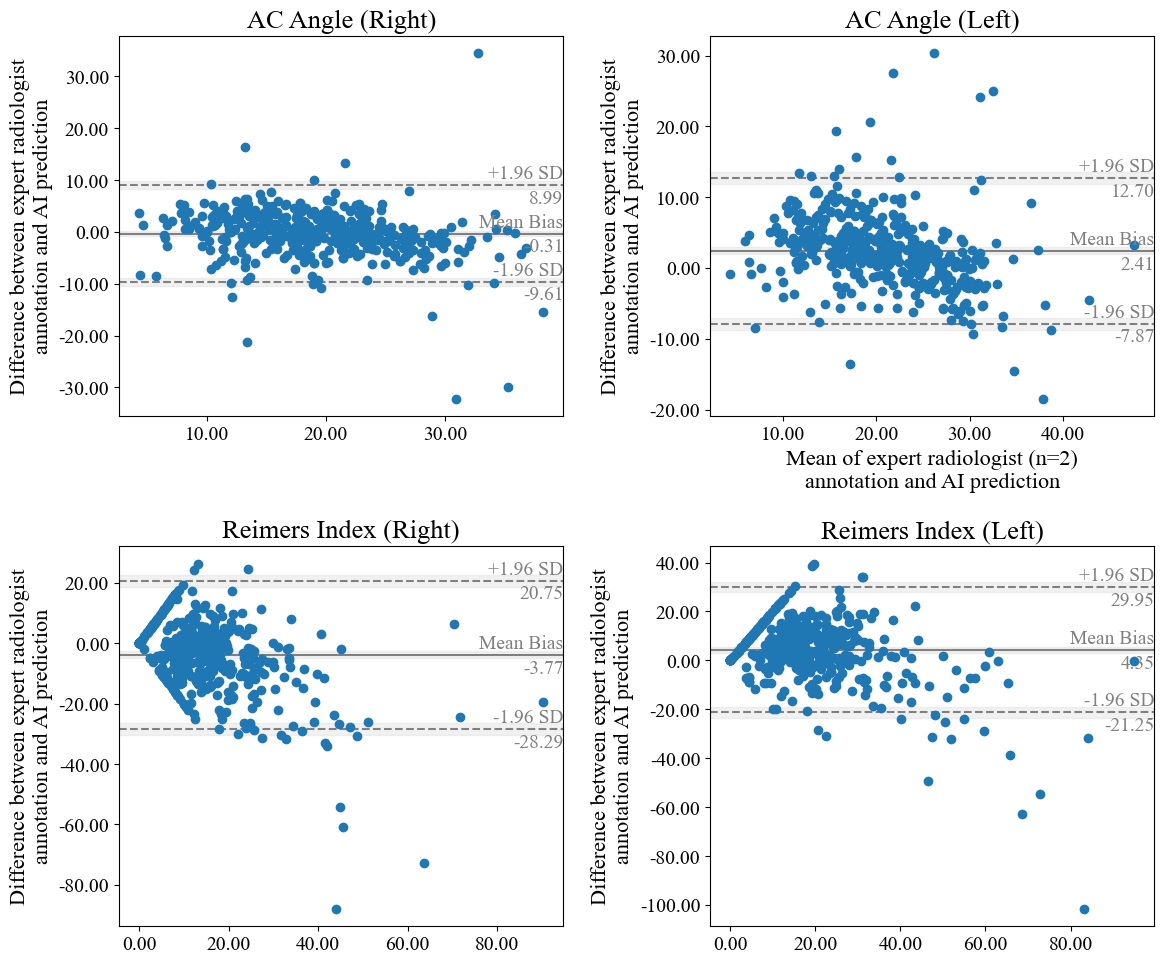

In [9]:
# Set Times New Roman as the default font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

small_font_size = 14
medium_font_size = 16
large_font_size = 19

# Determine which keys to plot
relevant_keys = [k for i,k in enumerate(measure_dict.keys()) if i in [0,1,2,3]]

# Create a figure with subplots
nrows = 2
ncols = int(np.ceil(len(relevant_keys)/nrows))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 10))

# Flatten axes array to easily loop over it
axes = axes.flatten()

for i, key in enumerate(relevant_keys):

    # Collapse dict by key
    # Collect measures
    measure_dict_predicted = []
    measure_dict_annotated = []
    for patient_key in results_by_id[key].keys():
        measure_dict_annotated.append(results_by_id[key][patient_key]['manual'])
        measure_dict_predicted.append(results_by_id[key][patient_key]['automatic'])

    #def bland_altman_plot(data1, data2, ax=None, title='Bland-Altman Plot', xlabel='Mean of Two Measurements', ylabel='Difference Between Measurements', save_path=None, *args, **kwargs):
    # bland_altman_plot(measure_dict_predicted[key], measure_dict_annotated[key], ax=ax, title=key, xlabel='Mean AI and Radiologist', ylabel='Difference Between AI and Radiologist', save_path=save_path)
    ax = axes[i]

    # The number of standard deviations to use for the limits of agreement (default is 1.96 for ~95% limits).
    limit=1.96

    # Calculate the mean and difference between measurements
    data1, data2 = np.array(measure_dict_predicted), np.array(measure_dict_annotated)
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)  # Mean difference
    sd = np.std(diff, axis=0)  # Standard deviation of differences
    n = len(diff)

    # Plotting on the specified axis
    ax.scatter(mean, diff, zorder=3)

    # Plot lines for mean difference and limits of agreement
    ax.axhline(md, color='gray', linestyle='-', zorder=2)
    ax.axhline(md + limit * sd, color='gray', linestyle='--', zorder=2)
    ax.axhline(md - limit * sd, color='gray', linestyle='--', zorder=2)

    # Add labels at the end of each line (outside the plot area on the right)
    x_lim = ax.get_xlim()  # Right edge of the plot
    y_lim = ax.get_ylim() # Top and bottom edge of the plot
    y_lim_diff = y_lim[1] - y_lim[0]

    ax.text(x_lim[1], md + y_lim_diff*0.03, 'Mean Bias', color='gray', va='center', ha='right', fontsize=small_font_size)
    ax.text(x_lim[1], md - y_lim_diff*0.035, '{0:.2f}'.format(md), color='gray', va='center', ha='right', fontsize=small_font_size)

    ax.text(x_lim[1], md + limit*sd + y_lim_diff*0.03, r'+1.96 SD', color='gray', va='center', ha='right', fontsize=small_font_size)
    ax.text(x_lim[1], md + limit*sd - y_lim_diff*0.035, '{0:.2f}'.format(md+limit*sd), color='gray', va='center', ha='right', fontsize=small_font_size)
    
    ax.text(x_lim[1], md - limit*sd + y_lim_diff*0.03, r'-1.96 SD', color='gray', va='center', ha='right', fontsize=small_font_size)
    ax.text(x_lim[1], md - limit*sd - y_lim_diff*0.035, '{0:.2f}'.format(md-limit*sd), color='gray', va='center', ha='right', fontsize=small_font_size)


    # Add 95% confidence intervals
    scale_mean_bias = sd/np.sqrt(n)
    ci_mean_bias = stats.t.interval(0.95, n-1, loc=md, scale=scale_mean_bias)
    ax.fill_between(np.linspace(x_lim[0], x_lim[1], len(mean)), ci_mean_bias[0], ci_mean_bias[1], color='lightgray', alpha=0.3, zorder=1)

    scale_loa = np.sqrt((sd**2 / n) + ((1.96 * sd)**2 / (2 * (n - 1))))
    ci_loa_upper = stats.t.interval(0.95, n-1, loc=md+limit*sd, scale=scale_loa)
    ci_loa_lower = stats.t.interval(0.95, n-1, loc=md-limit*sd, scale=scale_loa)
    ax.fill_between(np.linspace(x_lim[0], x_lim[1], len(mean)), ci_loa_upper[0], ci_loa_upper[1], color='lightgray', alpha=0.3, zorder=1)
    ax.fill_between(np.linspace(x_lim[0], x_lim[1], len(mean)), ci_loa_lower[0], ci_loa_lower[1], color='lightgray', alpha=0.3, zorder=1)


    # Style
    if i==nrows-1:
        ax.set_xlabel('Mean of expert radiologist (n=2)\nannotation and AI prediction', fontsize=medium_font_size)
    else:
        ax.set_xlabel('', fontsize=medium_font_size)

    title_text = key.replace('Talus-First Metatarsal Angle', 'Meary\'s Angle').replace('First-Second Intermetatarsal', 'I-II Metatarsal').replace('First-Fifth Intermetatarsal', 'I-V Metatarsal')
    title_text = title_text.replace(' (robust)', '')
    ax.set_title(title_text, fontsize=large_font_size)
    ax.set_ylabel('Difference between expert radiologist\nannotation and AI prediction', fontsize=medium_font_size)
    ax.tick_params(axis='both', labelsize=small_font_size) 
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}"))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.2f}"))

    ax.set_xlim(x_lim)

    plt.tight_layout(pad=2.0)

# plt.savefig(os.path.join(r'C:\Users\DEschweiler\Documents\Publications\EuropeanRadiology2024_MedicalLandmarkMatching\bland_altman', f'bland_altman_{anatomy}_{measurement_type}.svg'))

In [10]:
### Visualize single measurement

# Create DataFrame for Reimers Index (Right)
csa_df = pd.DataFrame([
    {
        'manual': data['manual'],
        'automatic': data['automatic'],
        'difference': data['difference']
    } 
    for patient_id, data in results_by_id['Reimers Index (Right)'].items()
], index=results_by_id['Reimers Index (Right)'].keys())

# Rename the index to be more descriptive
csa_df.index.name = 'patient_id'

# Round to 2 decimal places for better readability
csa_df = csa_df.round(2)

# Sort dataframe by "difference" column
csa_df = csa_df.sort_values(by='difference', ascending=False)

# Display the DataFrame
print(f"Reimers Index (Right) measurements for {len(csa_df)} patients:")
csa_df

# Save to csv file
#csa_df.to_csv(r'D:\experiments\MSK_Landmarks_2D\hva_feet_felix.csv', index=True)

Reimers Index (Right) measurements for 441 patients:


,manual,automatic,difference
patient_id,,,
9176260301_9176260301_frontal,88.00,0.00,88.00
9169782201_9169782201_frontal,100.00,27.20,72.80
9146187401_9146187401_frontal,76.00,15.09,60.91
9148961901_9148961901_frontal,72.00,17.92,54.08
9183628801_9183628801_frontal,59.00,24.98,34.02
9188560801_9188560801_frontal,58.00,25.04,32.96
9149293201_9149293201_frontal,48.80,16.99,31.81
9163199001_9163199001_frontal,43.00,11.76,31.24
9188628101_9188628101_frontal,64.00,33.37,30.63
